# 1.33b: Lattice Coordinate System

Computing ULP (Unit in Last Place) values for bfloat16 embedding weights.

## Goal

Establish the lattice spacing at each point in weight space so we can express displacements as integer multiples of the local ULP.

## The bfloat16 Lattice

bfloat16 format: `[sign: 1 bit][exponent: 8 bits][mantissa: 7 bits]`

For a value with exponent bits E (biased by 127):
- True exponent = E - 127
- ULP = 2^((E - 127) - 7) = 2^(E - 134)

Special cases:
- E = 0 (subnormals): ULP = 2^-133
- E = 255 (inf/nan): ULP = inf

## Parameters

In [1]:
THIMBLE_PATH = "../tensors/Thimble/thimble_7.h5"
OUTPUT_PATH = "../tensors/Thimble/1.33b_ulp_matrix.safetensors"

# Chunking parameters (matches HDF5 chunk shape for optimal I/O)
CHUNK_SIZE = 1600

RANDOM_SEED = 42

## Imports

In [2]:
import h5py
import torch
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from safetensors.torch import save_file

np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

print("✓ Imports complete")

✓ Imports complete


## Device Detection

In [3]:
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'

print(f"Using device: {device}")

Using device: mps


## Load Metadata Only

We'll load W in chunks during ULP computation to avoid memory issues.

In [4]:
print(f"Loading metadata from {THIMBLE_PATH}...\n")

with h5py.File(THIMBLE_PATH, 'r') as f:
    # Get shape without loading data
    n_steps, n_tokens, n_dims = f['W'].shape
    
    # Load dead token mask (small, only 10k bools)
    dead_mask = torch.from_numpy(f['dead_mask'][:]).bool()

n_dead = dead_mask.sum().item()
dead_token_ids = torch.where(dead_mask)[0]

print(f"✓ Loaded metadata")
print(f"  W shape: ({n_steps}, {n_tokens}, {n_dims})")
print(f"  Dead tokens: {n_dead} ({n_dead/n_tokens:.1%})")
print(f"  Total W size: {n_steps * n_tokens * n_dims * 2 / 1e9:.2f} GB")
print(f"\nWill process in chunks of {CHUNK_SIZE} steps")

Loading metadata from ../tensors/Thimble/thimble_7.h5...

✓ Loaded metadata
  W shape: (6001, 10000, 64)
  Dead tokens: 3699 (37.0%)
  Total W size: 7.68 GB

Will process in chunks of 1600 steps


## Compute ULP Matrix (Chunked)

Load W in chunks from HDF5 and compute ULP incrementally to stay within memory budget.

In [5]:
print("Computing ULP matrix in chunks...\n")

def compute_ulp_bf16(x):
    """
    Compute ULP for bfloat16 values using closed-form arithmetic.
    
    For bfloat16 with exponent bits E (biased by 127):
    ULP = 2^(E - 134)
    
    Args:
        x: bfloat16 tensor
    
    Returns:
        ULP values as bfloat16 tensor (same device as input)
    """
    # Extract exponent bits from bfloat16
    # bfloat16 format: [sign: 1 bit][exponent: 8 bits][mantissa: 7 bits]
    x_uint16 = x.view(torch.uint16)
    exponent = (x_uint16 >> 7) & 0xFF  # Shift right 7, mask to 8 bits
    
    # Compute ULP = 2^(exponent - 134)
    # Use exp2 (more efficient than pow) and compute exponent in float32
    exponent_f32 = exponent.to(torch.float32) - 134
    ulp_f32 = torch.exp2(exponent_f32)
    
    # Handle special cases (stay in float32 until after torch.where):
    # - Exponent 0 (subnormals): ULP = 2^-133 (smallest subnormal spacing)
    # - Exponent 255 (inf/nan): ULP = inf
    # Note: 2^-133 underflows in bfloat16, so we keep it in float32
    # Cast exponent to int32 for comparison (uint16 doesn't support promotion)
    exponent_i32 = exponent.to(torch.int32)
    
    # For subnormals (E=0), the ULP is the smallest subnormal step: 2^-133
    # This is too small for bfloat16, so we'll use the smallest representable
    # positive bfloat16 value instead (2^-133 rounds to 0 in bf16)
    # Actually: smallest normal bf16 is 2^-126, smallest subnormal is 2^-133
    # But 2^-133 can't be represented in bf16. So for E=0 values, 
    # the ULP should be the smallest positive bf16: ~9.18e-41 (subnormal)
    # Let's use torch.finfo to get this right.
    smallest_subnormal_f32 = torch.finfo(torch.bfloat16).tiny  # Actually smallest normal
    # Smallest subnormal bf16 = 2^-126 * 2^-7 = 2^-133 ≈ 9.18e-41
    # But bf16 can't represent this! Smallest bf16 subnormal is 2^-126 * 2^-6 = 2^-132
    # Actually let me just compute: for E=0, mantissa bits give 2^-126 * m/128
    # Smallest is m=1: 2^-126 / 128 = 2^-133... which underflows.
    # 
    # The right answer: for exact zero (E=0, M=0), there IS no ULP in the usual sense.
    # For subnormals (E=0, M>0), ULP = 2^-133.
    # Since we can't represent 2^-133 in bf16, let's keep the result in float32
    # OR use a sentinel value. For now, let's just use the smallest positive bf16.
    
    # Smallest positive bfloat16 (subnormal): bit pattern 0x0001
    smallest_pos_bf16 = torch.tensor(1, dtype=torch.uint16, device=x.device).view(torch.bfloat16).to(torch.float32)
    
    ulp_f32 = torch.where(exponent_i32 == 0, smallest_pos_bf16, ulp_f32)
    ulp_f32 = torch.where(exponent_i32 == 255, float('inf'), ulp_f32)
    
    # Quantize to bfloat16
    ulp_bf16 = ulp_f32.to(torch.bfloat16)
    
    return ulp_bf16

# Process W in chunks
U_chunks = []

with h5py.File(THIMBLE_PATH, 'r') as f:
    for start in range(0, n_steps, CHUNK_SIZE):
        end = min(start + CHUNK_SIZE, n_steps)
        print(f"  Processing steps {start}:{end} ({end - start} steps)...")
        
        # Load only this chunk from HDF5
        W_chunk = torch.from_numpy(f['W'][start:end]).view(torch.bfloat16).to(device)
        
        # Compute ULP for this chunk
        U_chunk = compute_ulp_bf16(W_chunk)
        
        # Store chunk (stays on device)
        U_chunks.append(U_chunk)
        
        # Free W_chunk
        del W_chunk
        torch.mps.empty_cache()

# Concatenate all chunks
print(f"\nConcatenating {len(U_chunks)} chunks...")
U = torch.cat(U_chunks, dim=0)

# Free chunk list
del U_chunks
torch.mps.empty_cache()

print(f"\n✓ ULP matrix computed")
print(f"  Shape: {U.shape}")
print(f"  Dtype: {U.dtype}")
print(f"  Memory: {U.element_size() * U.nelement() / 1e9:.2f} GB")

Computing ULP matrix in chunks...

  Processing steps 0:1600 (1600 steps)...
  Processing steps 1600:3200 (1600 steps)...
  Processing steps 3200:4800 (1600 steps)...
  Processing steps 4800:6001 (1201 steps)...

Concatenating 4 chunks...

✓ ULP matrix computed
  Shape: torch.Size([6001, 10000, 64])
  Dtype: torch.bfloat16
  Memory: 7.68 GB


## Sanity Checks

Basic validation of the ULP computation.

In [6]:
print("\nRunning sanity checks...\n")

# MPS has severe limitations with tensors > INT_MAX elements.
# Move U to CPU for sanity checks (one-time cost, ~8GB, but it works).
print("Moving U to CPU for sanity checks...")
U_cpu = U.cpu()
print("Done.\n")

# Check 1: Count zeros and diagnose them
print(f"Check 1: Zero ULP values")
n_zeros = (U_cpu == 0).sum().item()
n_total = U_cpu.numel()

print(f"  Total elements: {n_total:,}")
print(f"  Zero ULPs: {n_zeros:,}")
if n_zeros > 0:
    print(f"  ⚠️  WARNING: Found {n_zeros} zero ULP values!")
    
    # Find examples and diagnose what W values cause them
    zero_indices = torch.where(U_cpu == 0)
    print(f"\n  Diagnosing zero-ULP W values (showing first 10):")
    with h5py.File(THIMBLE_PATH, 'r') as f:
        W_data = f['W']
        for i in range(min(10, n_zeros)):
            t = zero_indices[0][i].item()
            tok = zero_indices[1][i].item()
            d = zero_indices[2][i].item()
            
            # Get raw uint16 bits from HDF5
            w_bits = W_data[t, tok, d]
            
            # Interpret as bfloat16
            w_bf16 = torch.tensor(w_bits, dtype=torch.uint16).view(torch.bfloat16)
            w_float = float(w_bf16)
            
            # Extract exponent and mantissa
            exponent = (w_bits >> 7) & 0xFF
            mantissa = w_bits & 0x7F
            sign = (w_bits >> 15) & 0x1
            
            print(f"    [{t}, {tok}, {d}]: bits=0x{w_bits:04X}, "
                  f"sign={sign}, exp={exponent}, mant={mantissa}, "
                  f"value={w_float:.6e}")
else:
    print(f"  ✓ PASS: No zero ULP values")

print()

# Check 2: Range statistics
print(f"Check 2: ULP range statistics")
print(f"  Min ULP: {U_cpu.min().item():.6e}")
print(f"  Max ULP: {U_cpu.max().item():.6e}")
print(f"  (Skipping median - requires full sort)")

# Check for inf/nan
n_inf = torch.isinf(U_cpu).sum().item()
n_nan = torch.isnan(U_cpu).sum().item()
if n_inf > 0 or n_nan > 0:
    print(f"  ⚠️  Found {n_inf:,} inf and {n_nan:,} nan values")
else:
    print(f"  ✓ No inf/nan values")

print()

# Check 3: ULP vs W magnitude (small random sample)
print(f"Check 3: ULP vs W magnitude (sampled)")
sample_size = 10000

# Generate random indices
torch.manual_seed(RANDOM_SEED)
t_indices = torch.randint(0, n_steps, (sample_size,))
tok_indices = torch.randint(0, n_tokens, (sample_size,))
d_indices = torch.randint(0, n_dims, (sample_size,))

# Sample U values (from CPU copy)
U_sample = U_cpu[t_indices, tok_indices, d_indices]

# Load corresponding W values from HDF5 - PROPERLY convert uint16 -> bfloat16
W_sample = torch.empty(sample_size, dtype=torch.bfloat16)
with h5py.File(THIMBLE_PATH, 'r') as f:
    W_data = f['W']
    for i in range(sample_size):
        t, tok, d = t_indices[i].item(), tok_indices[i].item(), d_indices[i].item()
        w_bits = W_data[t, tok, d]
        # Convert uint16 bit pattern to bfloat16
        W_sample[i] = torch.tensor(w_bits, dtype=torch.uint16).view(torch.bfloat16)

# Convert to float32 for ratio calculation
W_sample_f32 = W_sample.to(torch.float32)
U_sample_f32 = U_sample.to(torch.float32)

# Compute ratio for non-zero W
W_abs = W_sample_f32.abs()
nonzero_mask = W_abs > 0
if nonzero_mask.sum() > 0:
    ratio = U_sample_f32[nonzero_mask] / W_abs[nonzero_mask]
    print(f"  ULP/|W| ratio statistics (sample of {sample_size:,}, {nonzero_mask.sum().item():,} non-zero W):")
    print(f"    Min: {ratio.min().item():.6e}")
    print(f"    Max: {ratio.max().item():.6e}")
    print(f"    Median: {ratio.median().item():.6e}")
    print(f"  (For any W, expect ratio ≈ 2^-7 = 0.0078125)")
else:
    print(f"  ⚠️  All sampled W values are zero!")

print()

# Check 4: ULP distribution (from sample)
print(f"Check 4: ULP distribution (from sample)")
U_sample_nonzero = U_sample_f32[U_sample_f32 > 0]
if len(U_sample_nonzero) > 0:
    U_log10 = torch.log10(U_sample_nonzero)
    print(f"  Log10(ULP) range: [{U_log10.min().item():.1f}, {U_log10.max().item():.1f}]")
else:
    print(f"  ⚠️  No non-zero ULP values in sample!")

# Keep U_cpu around for visualization (don't delete yet)

print("\n" + "="*80)
print("✓ Sanity checks complete")
print("="*80)


Running sanity checks...

Moving U to CPU for sanity checks...
Done.

Check 1: Zero ULP values
  Total elements: 3,840,640,000
  Zero ULPs: 263
  ⚠️  WARNING: Found 263 zero ULP values!

  Diagnosing zero-ULP W values (showing first 10):
    [2, 3614, 23]: bits=0x0000, sign=0, exp=0, mant=0, value=0.000000e+00
    [2, 9668, 35]: bits=0x0000, sign=0, exp=0, mant=0, value=0.000000e+00
    [3, 9623, 6]: bits=0x0000, sign=0, exp=0, mant=0, value=0.000000e+00
    [4, 3267, 45]: bits=0x0000, sign=0, exp=0, mant=0, value=0.000000e+00
    [4, 6055, 54]: bits=0x0000, sign=0, exp=0, mant=0, value=0.000000e+00
    [5, 1619, 16]: bits=0x0000, sign=0, exp=0, mant=0, value=0.000000e+00
    [5, 9158, 22]: bits=0x0000, sign=0, exp=0, mant=0, value=0.000000e+00
    [8, 3505, 15]: bits=0x0000, sign=0, exp=0, mant=0, value=0.000000e+00
    [9, 2630, 21]: bits=0x0000, sign=0, exp=0, mant=0, value=0.000000e+00
    [9, 6670, 21]: bits=0x0000, sign=0, exp=0, mant=0, value=0.000000e+00

Check 2: ULP range st

## Visualization: ULP Distribution

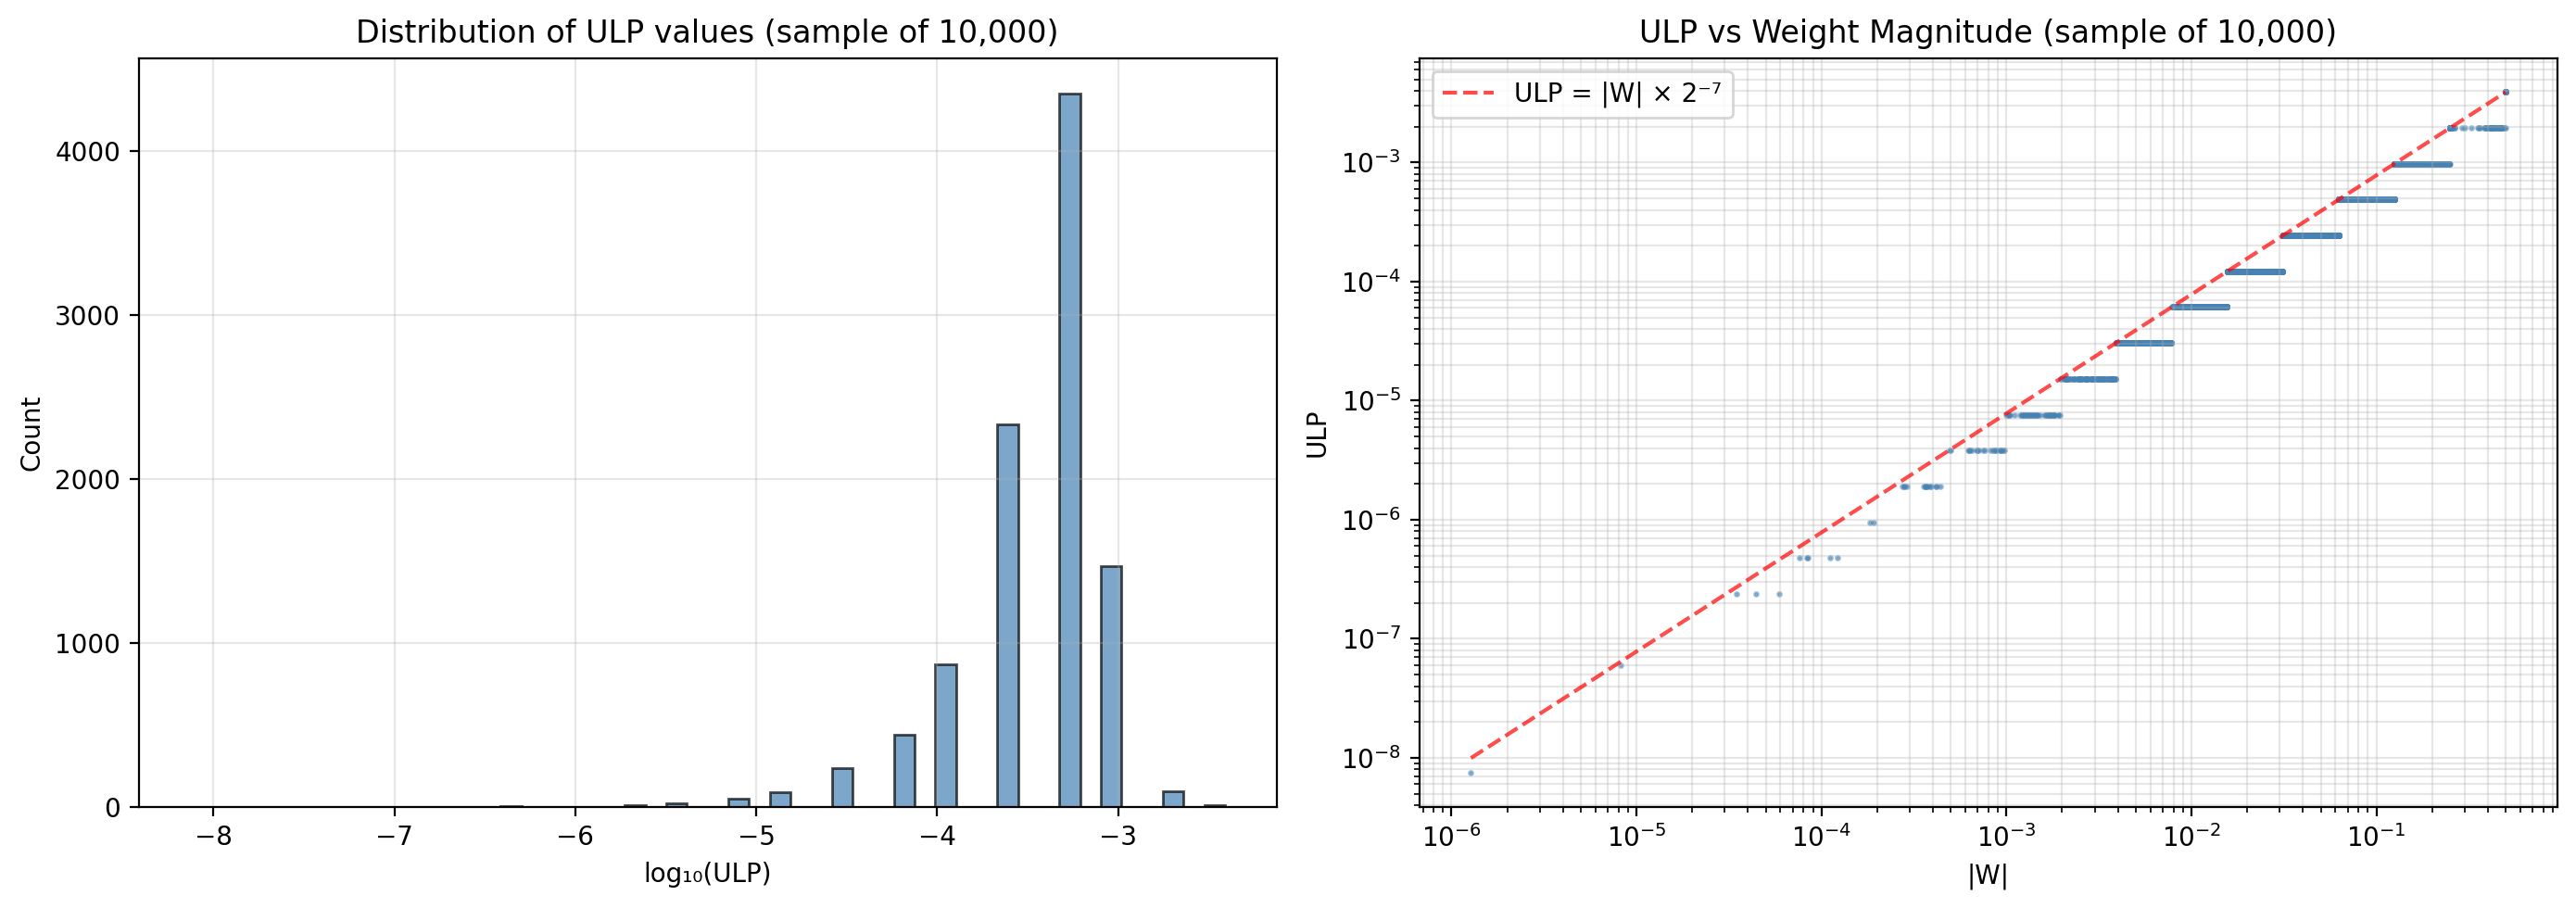

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5), dpi=200)

# Use the sample we already have from sanity checks
# (U_sample_f32, W_sample_f32 are still in scope)

# Plot 1: Histogram of log10(ULP)
U_sample_np = U_sample_f32.numpy()
U_nonzero = U_sample_np[U_sample_np > 0]
U_log10 = np.log10(U_nonzero)
ax1.hist(U_log10, bins=50, color='steelblue', alpha=0.7, edgecolor='black')
ax1.set_xlabel('log₁₀(ULP)')
ax1.set_ylabel('Count')
ax1.set_title(f'Distribution of ULP values (sample of {len(U_nonzero):,})')
ax1.grid(True, alpha=0.3)

# Plot 2: ULP vs |W| scatter
W_sample_np = W_sample_f32.numpy()
W_abs = np.abs(W_sample_np)
nonzero = (W_abs > 0) & (U_sample_np > 0)
ax2.scatter(W_abs[nonzero], U_sample_np[nonzero], s=2, alpha=0.5, color='steelblue')
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_xlabel('|W|')
ax2.set_ylabel('ULP')
ax2.set_title(f'ULP vs Weight Magnitude (sample of {nonzero.sum():,})')
ax2.grid(True, alpha=0.3, which='both')

# Add reference line: ULP = |W| * 2^-7 (expected relationship)
w_range = np.logspace(np.log10(W_abs[nonzero].min()), np.log10(W_abs[nonzero].max()), 100)
ax2.plot(w_range, w_range * 2**-7, 'r--', alpha=0.7, label='ULP = |W| × 2⁻⁷')
ax2.legend(loc='best')

plt.tight_layout()
plt.show()

# Now we can free U_cpu
del U_cpu

## Save Results (Optional)

Uncomment to save the ULP matrix for future use.

In [10]:
# Uncomment to save ULP matrix

print(f"Saving ULP matrix to {OUTPUT_PATH}...\n")

save_dict = {
    'U': U.cpu(),
    'dead_mask': dead_mask,
    'dead_token_ids': dead_token_ids,
    # Metadata
    'n_steps': torch.tensor(n_steps),
    'n_tokens': torch.tensor(n_tokens),
    'n_dims': torch.tensor(n_dims),
    'n_dead': torch.tensor(n_dead),
}

save_file(save_dict, OUTPUT_PATH)

file_size_gb = Path(OUTPUT_PATH).stat().st_size / 1e9

print(f"✓ Saved to {OUTPUT_PATH}")
print(f"  File size: {file_size_gb:.2f} GB")

Saving ULP matrix to ../tensors/Thimble/1.33b_ulp_matrix.safetensors...

✓ Saved to ../tensors/Thimble/1.33b_ulp_matrix.safetensors
  File size: 7.68 GB
